In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
try:
    import cupy as cp
    use_gpu = True
except:
    use_gpu = False
import pickle
import time
from corner import corner
import h5py

from stableemrifisher.fisher import StableEMRIFisher
from stableemrifisher.utils import inner_product, generate_PSD, padding
from stableemrifisher.plot import CovEllipsePlot

from few.utils.utility import get_p_at_t
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux

from few.waveform import GenerateEMRIWaveform
from few.summation.aakwave import AAKSummation
from few.utils.constants import YRSID_SI
from few.utils.constants import SPEED_OF_LIGHT as C_SI
from few.utils.geodesic import ELQ_to_pex, get_kerr_geo_constants_of_motion

from fastlisaresponse import ResponseWrapper  # Response function 
from lisatools.detector import ESAOrbits #ESAOrbits correspond to esa-trailing-orbits.h5
from lisatools.sensitivity import get_sensitivity, A1TDISens, E1TDISens, T1TDISens

from scipy.integrate import quad, nquad
from scipy.interpolate import RegularGridInterpolator, CubicSpline
from scipy.stats import uniform
from scipy.special import factorial
from scipy.optimize import brentq, root

from scipy.stats import multivariate_normal
import warnings

from hierarchical.FisherValidation import FisherValidation
from hierarchical.utility import H, integrand_dc, dc, getdistGpc, dlminusdistz, getz, Jacobian, check_prior
from hierarchical.JointWave import JointKerrWaveform, JointRelKerrEccFlux

#lots of supporting utility functions

if not use_gpu:
    cfg_set = few.get_config_setter(reset=True)
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info")
else:
    pass #let the backend decide for itself.

startup


In [2]:
T_LISA = 1. #LISA observation duration
dt = 10.0 #sampling rate

max_step_days = 20.0 #maximum step size for inspiral calculation. Smaller number ensures a more accurate trajectory but requires higher computation time.

insp_kwargs = { "err": 1e-11, #Default: 1e-11 in FEW 2
                "max_step_size": max_step_days*24*60*60, #in seconds
                "buffer_length":int(1e6), 
               }

sum_kwargs = {
    "pad_output": True, # True if expecting waveforms smaller than LISA observation window.
}

Waveform_model = GenerateEMRIWaveform(
            JointKerrWaveform,
            inspiral_kwargs=insp_kwargs,
            sum_kwargs=sum_kwargs,
            use_gpu=use_gpu,
            return_list=False,
            frame="detector"
            )

#orbit_file_esa = "/home/shubham/FEW_KerrEcc/Github_Repos/lisa-on-gpu/orbit_files/esa-trailing-orbits.h5"
# orbit_file_esa = "/data/lsperi/lisa-on-gpu/orbit_files/equalarmlength-trailing-fit.h5"
#orbit_kwargs_esa = dict(orbit_file=orbit_file_esa)

tdi_gen ="1st generation"# "2nd generation"#

order = 20  # interpolation order (should not change the result too much)
tdi_kwargs_esa = dict(
    orbits=ESAOrbits(use_gpu=use_gpu), order=order, tdi=tdi_gen, tdi_chan="AE",
)  # could do "AET"

index_lambda = 8
index_beta = 7

# with longer signals we care less about this
t0 = 10000.0  # throw away on both ends when our orbital information is weird

EMRI_TDI = ResponseWrapper(
                        Waveform_model,
                        T_LISA,
                        t0=t0,
                        dt=dt,
                        index_lambda=index_lambda,
                        index_beta=index_beta,
                        flip_hx=True,  # set to True if waveform is h+ - ihx (FEW is)
                        use_gpu=use_gpu,
                        is_ecliptic_latitude=False,  # False if using polar angle (theta)
                        remove_garbage="zero",  # removes the beginning of the signal that has bad information
                        **tdi_kwargs_esa,
                        )

In [3]:
#cosmological parameters
cosmo_params={'Omega_m0':0.30,'Omega_Lambda0':0.70,'H0':70e3}

#Mstar normalization term for the EMRI MBH mass distribution
Mstar = 3e6

#True size of the population
Npop = int(1e2)

#detection SNR threshold
SNR_thresh = 20.0

#true values of population hyperparameters.
true_hyper={'K':5e-3,'alpha':0.2,'beta':0.2, #vacuum hyperparameters
            'f':0.5,'mu_Al':1e-5,'mu_nl':8.0,'sigma_Al':1e-6,'sigma_nl':1.0, #local effect hyper
            'Gdot':1e-9 #global effect hyper
           }

#prior bounds on source parameters
source_bounds={'M':[1e5,1e7],'z':[0.01,1.0], #vacuum parameters
               'Al':[0.0,1e-4],'nl':[0.0,20.0], #local effect parameters
               'Ag':[0.0,1e-8] #global effect parameters
              }

#prior bounds on population hyperparameters
hyper_bounds={'K':[1e-3,1e-2],'alpha':[-0.5,0.5],'beta':[-0.5,0.5], #vacuum hyperparameters
             'f':[0.0,1.0],'mu_Al':[true_hyper['mu_Al']*0.9,true_hyper['mu_Al']*1.1],'mu_nl':[true_hyper['mu_nl']*0.9,true_hyper['mu_nl']*1.1],
              'sigma_Al':[true_hyper['sigma_Al']*1e-1,true_hyper['sigma_Al']*1e2],
              'sigma_nl':[true_hyper['sigma_nl']*1e-1,true_hyper['sigma_nl']*1e2],#local effect hyper
             'Gdot':source_bounds['Ag'] #global effect hyper
             }

In [4]:
filename_Fishers_loc = 'Fishers_loc' #subfolder with inferred FIMs in local hypothesis
filename_Fishers_glob = 'Fishers_glob' #subfolder with inferred FIMs in global hypothesis

Fisher_validation_kwargs = {'filename_Fishers_loc':filename_Fishers_loc,
                            'filename_Fishers_glob':filename_Fishers_glob,
                            'validate':False,'KL_threshold':10.0}

In [5]:
filename = f'Hierarchical_Npop_{Npop}_f_{true_hyper['f']}_Gdot_{true_hyper['Gdot']}_K_{true_hyper['K']}_alpha_{true_hyper['alpha']}_beta_{true_hyper['beta']}' #folder with all the analysis data and plots
#filename = f'Hierarchical_Npop_{Npop}_varied_f_Gdot_{true_hyper['Gdot']}_K_{true_hyper['K']}_alpha_{true_hyper['alpha']}_beta_{true_hyper['beta']}/f_{true_hyper['f']}' #folder with all the analysis data and plots
#filename = 'test_Tplunge'
filename_Fishers = 'Fishers' #subfolder with all the Fisher matrices

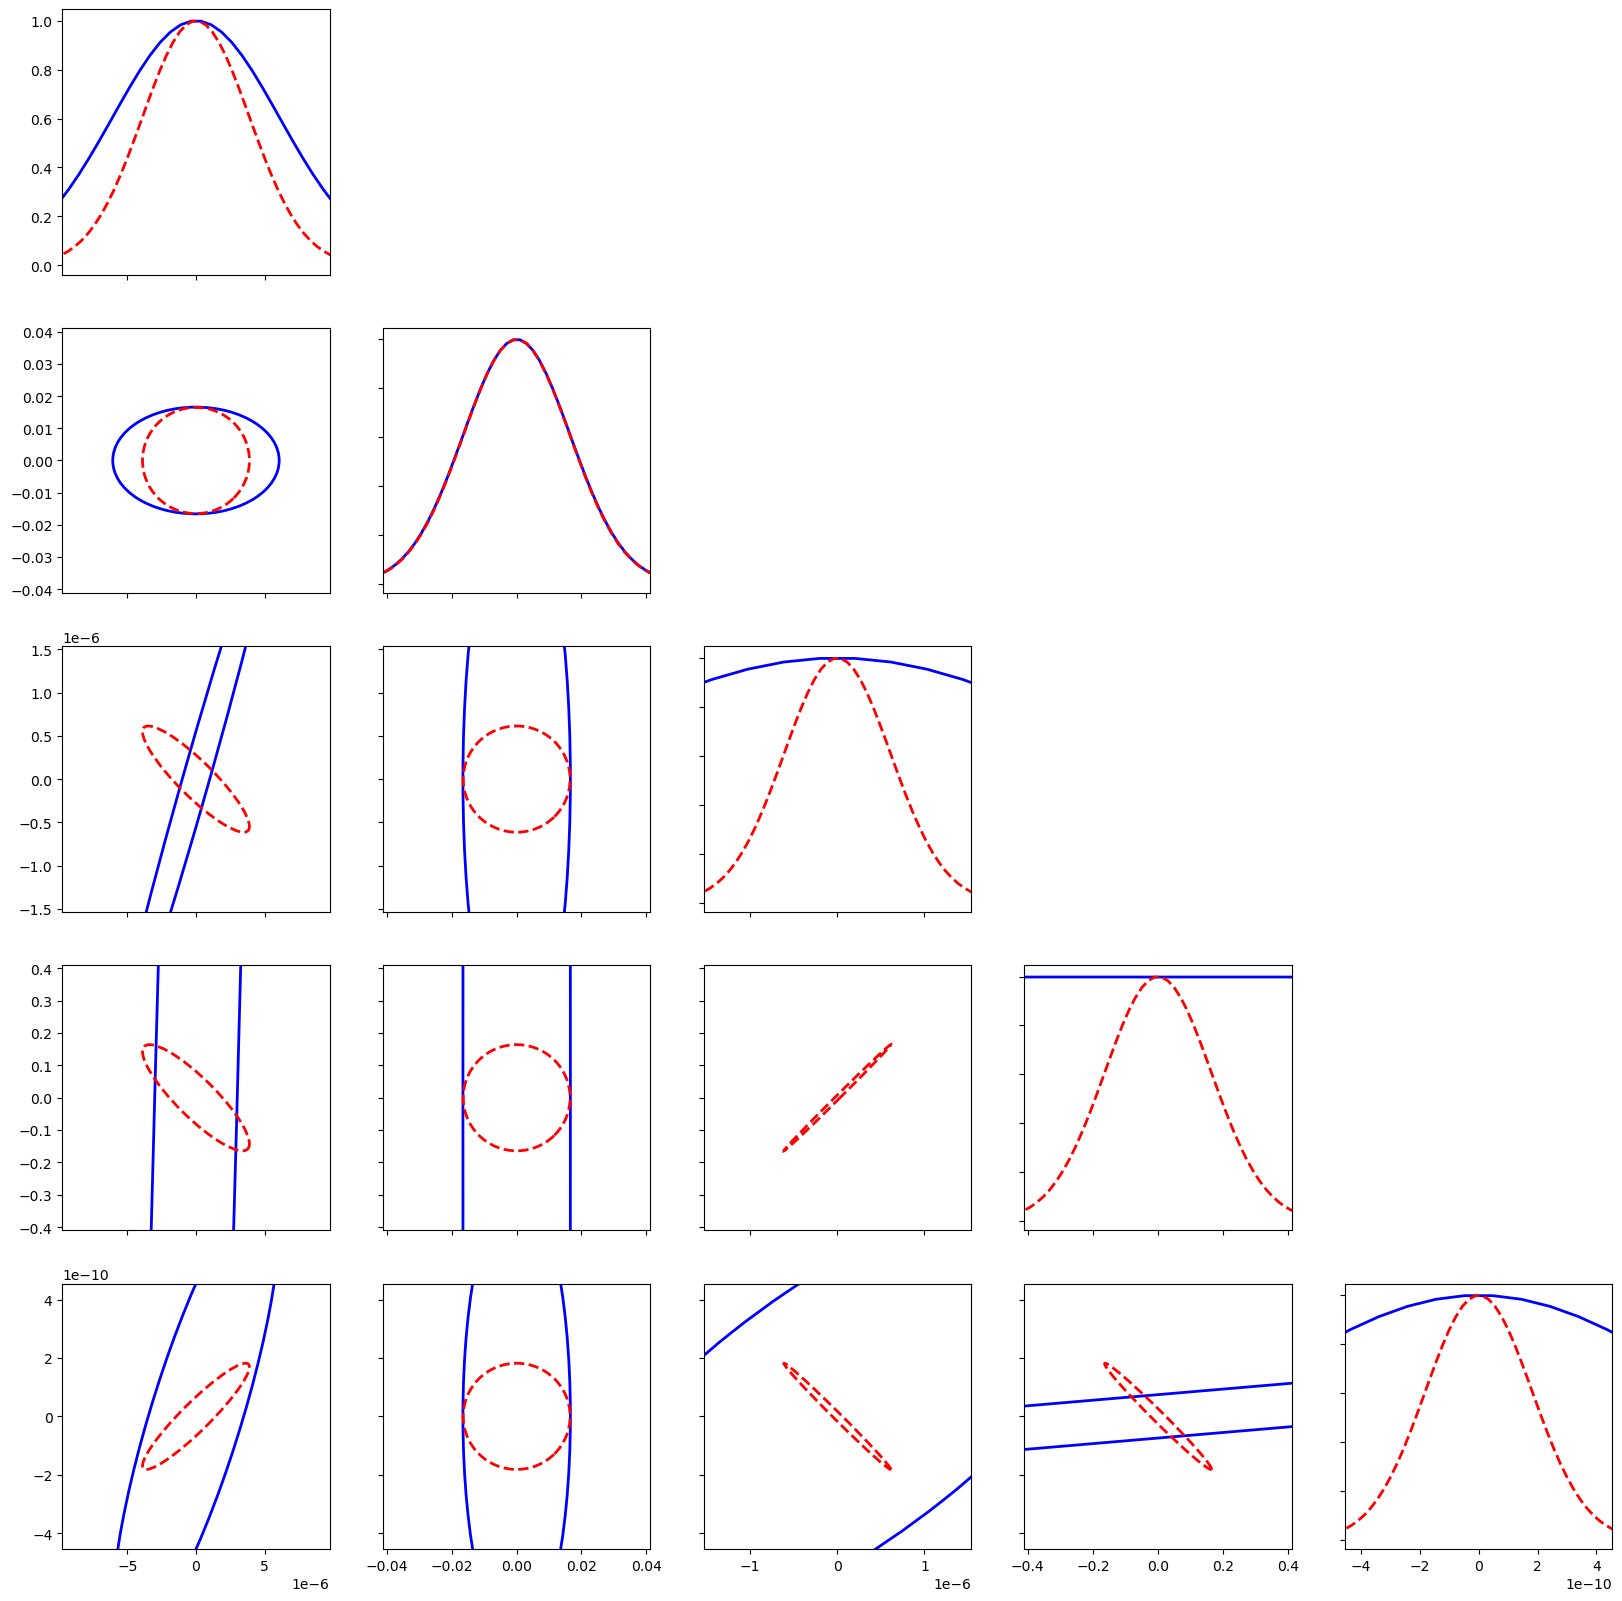

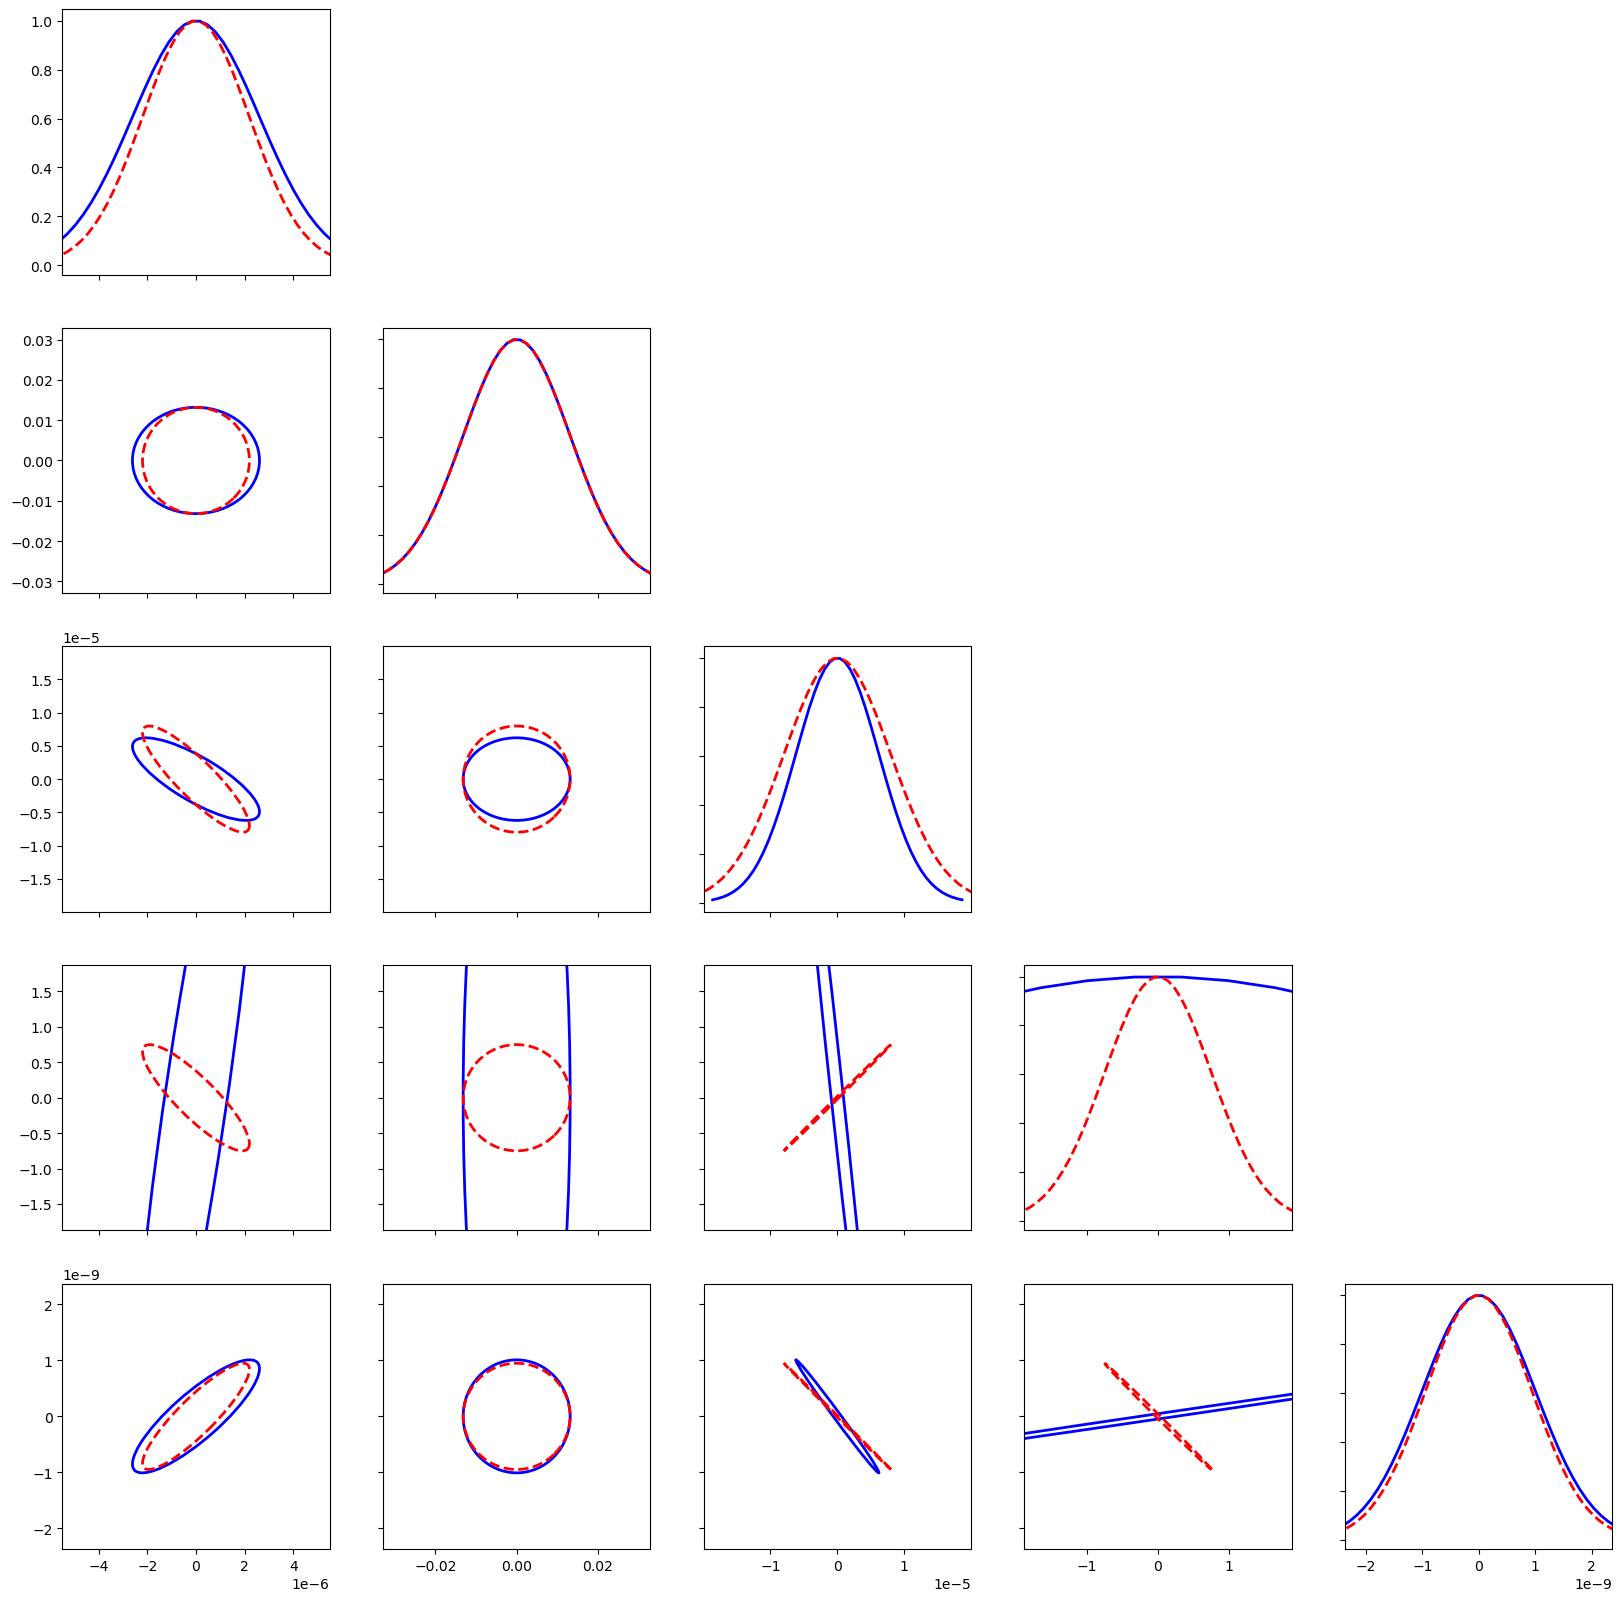

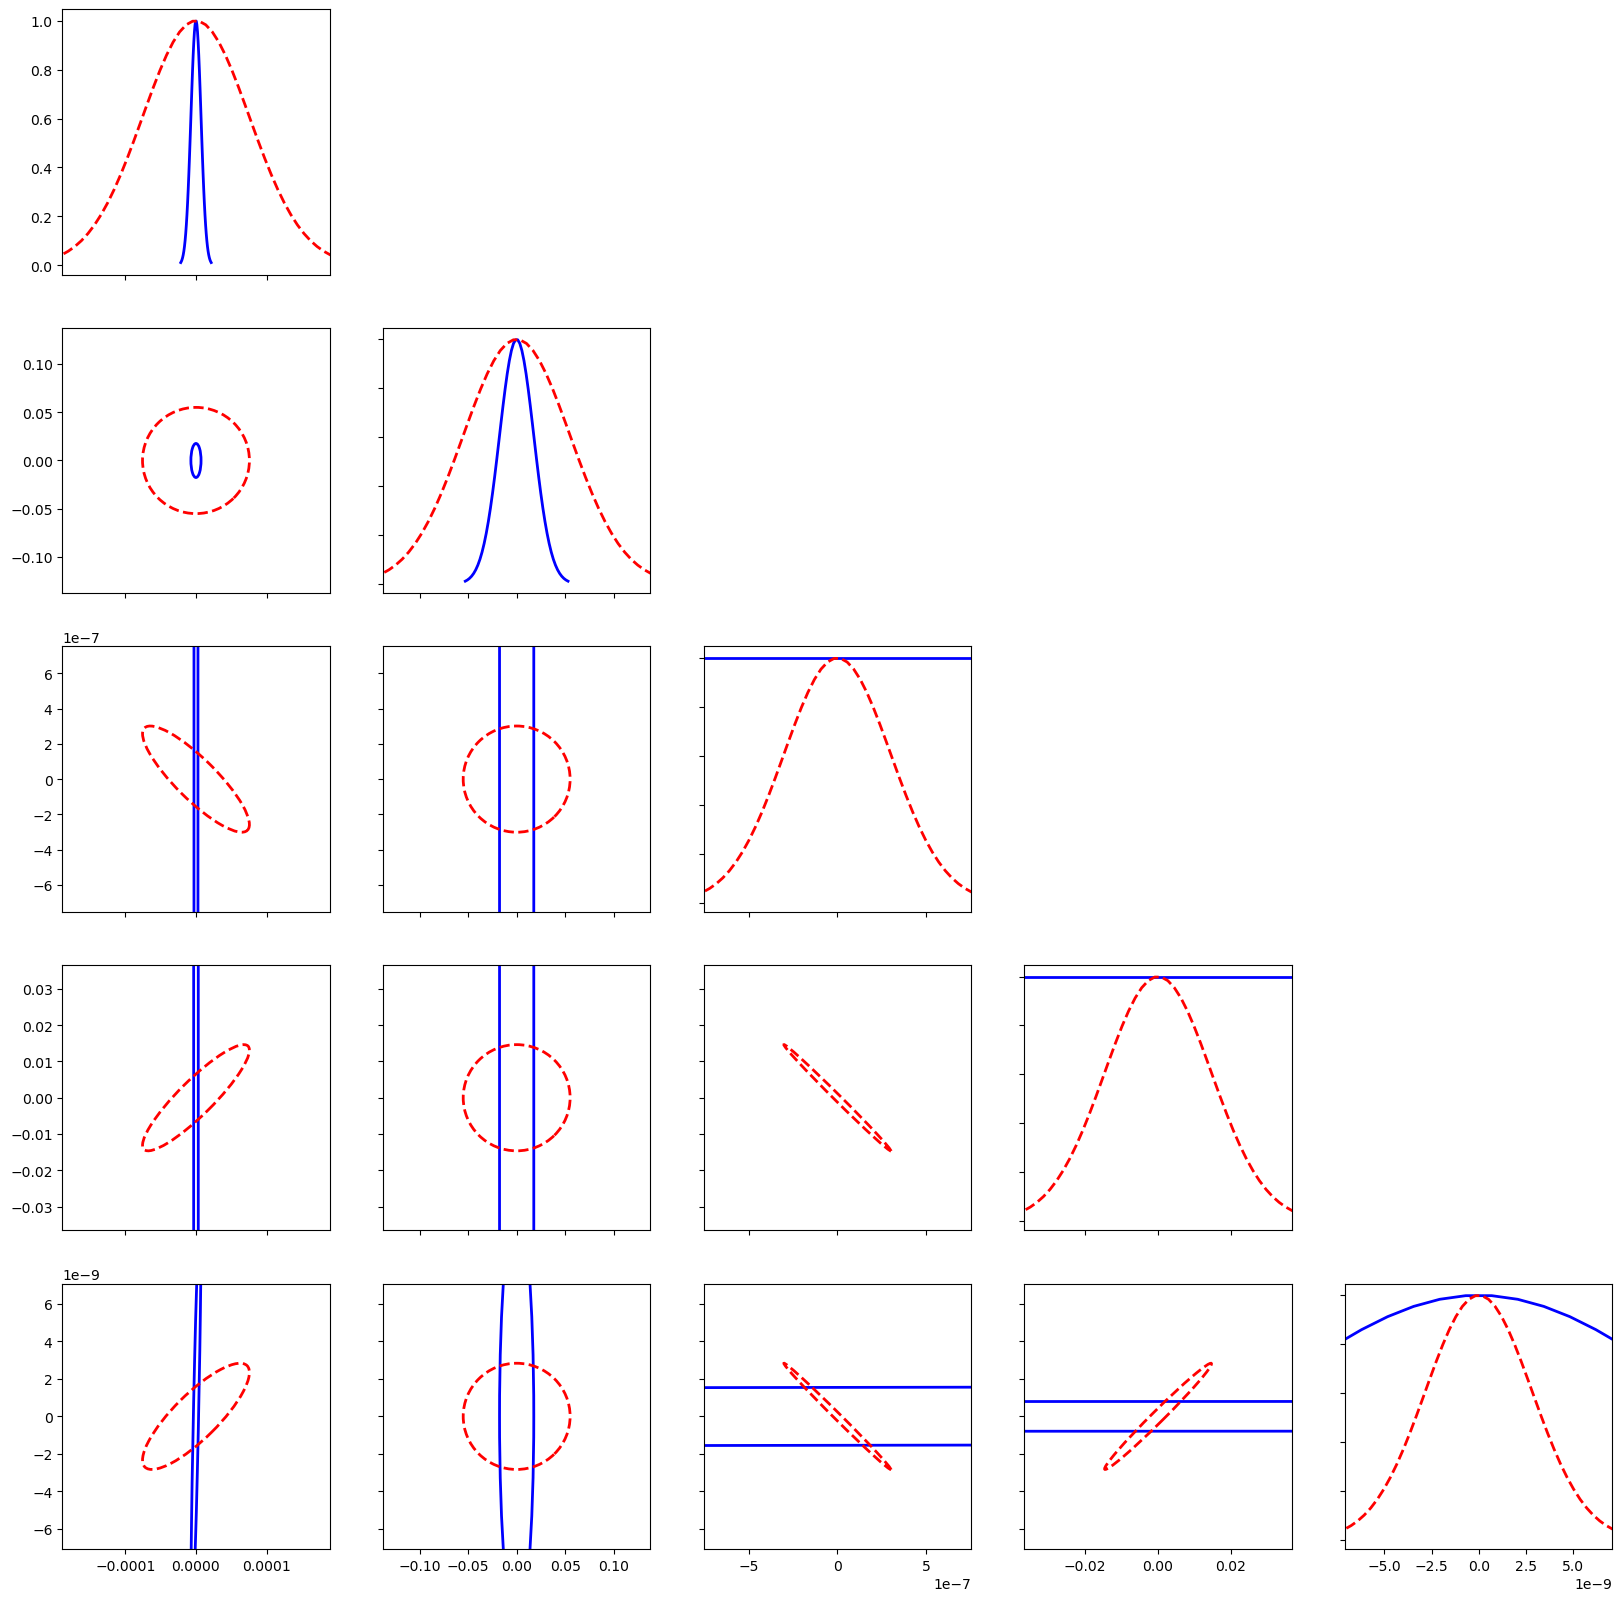

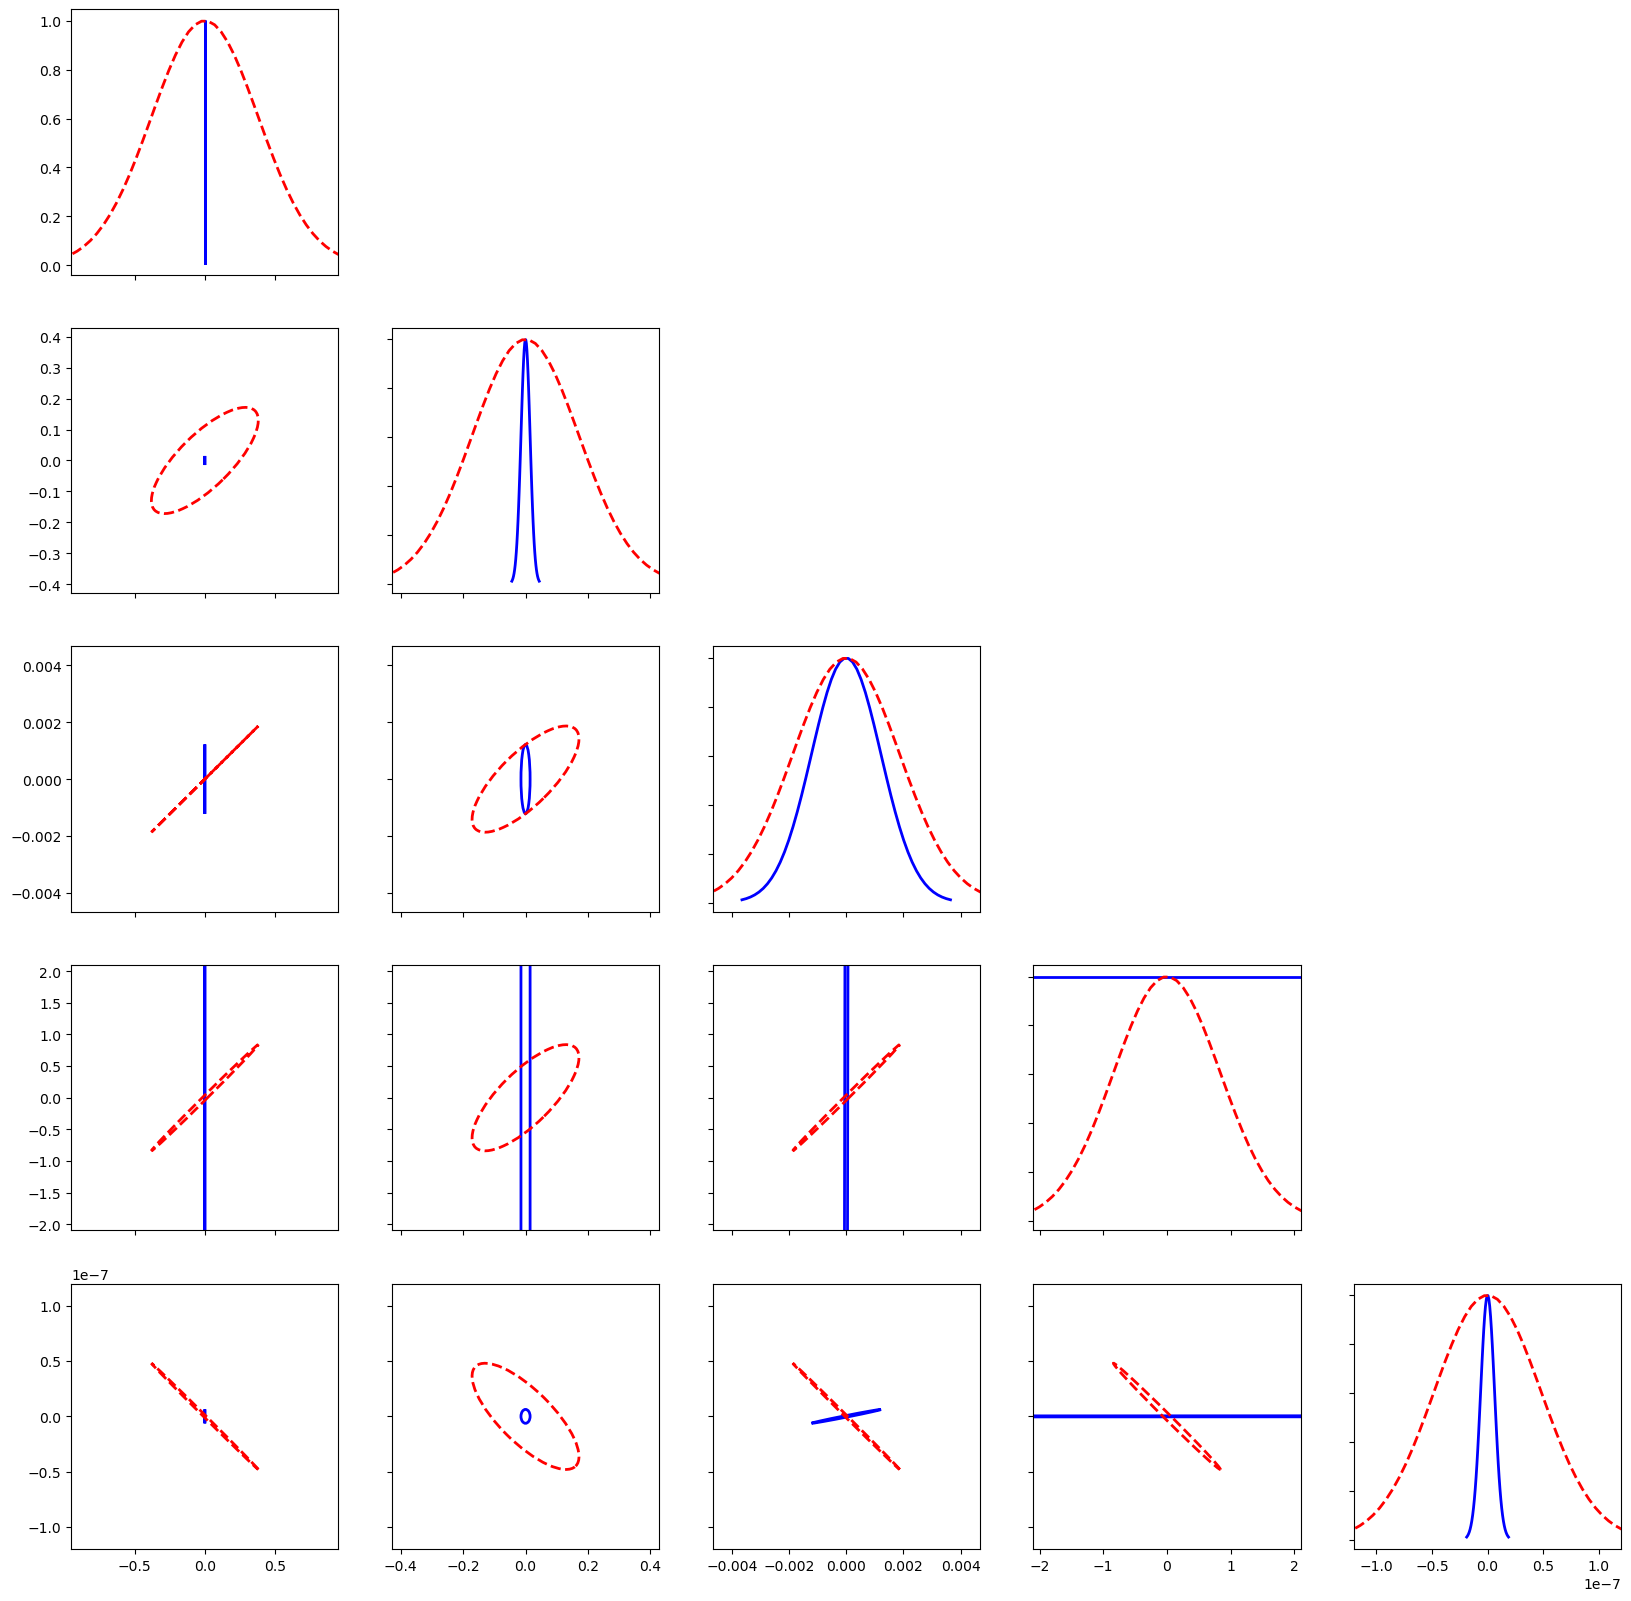

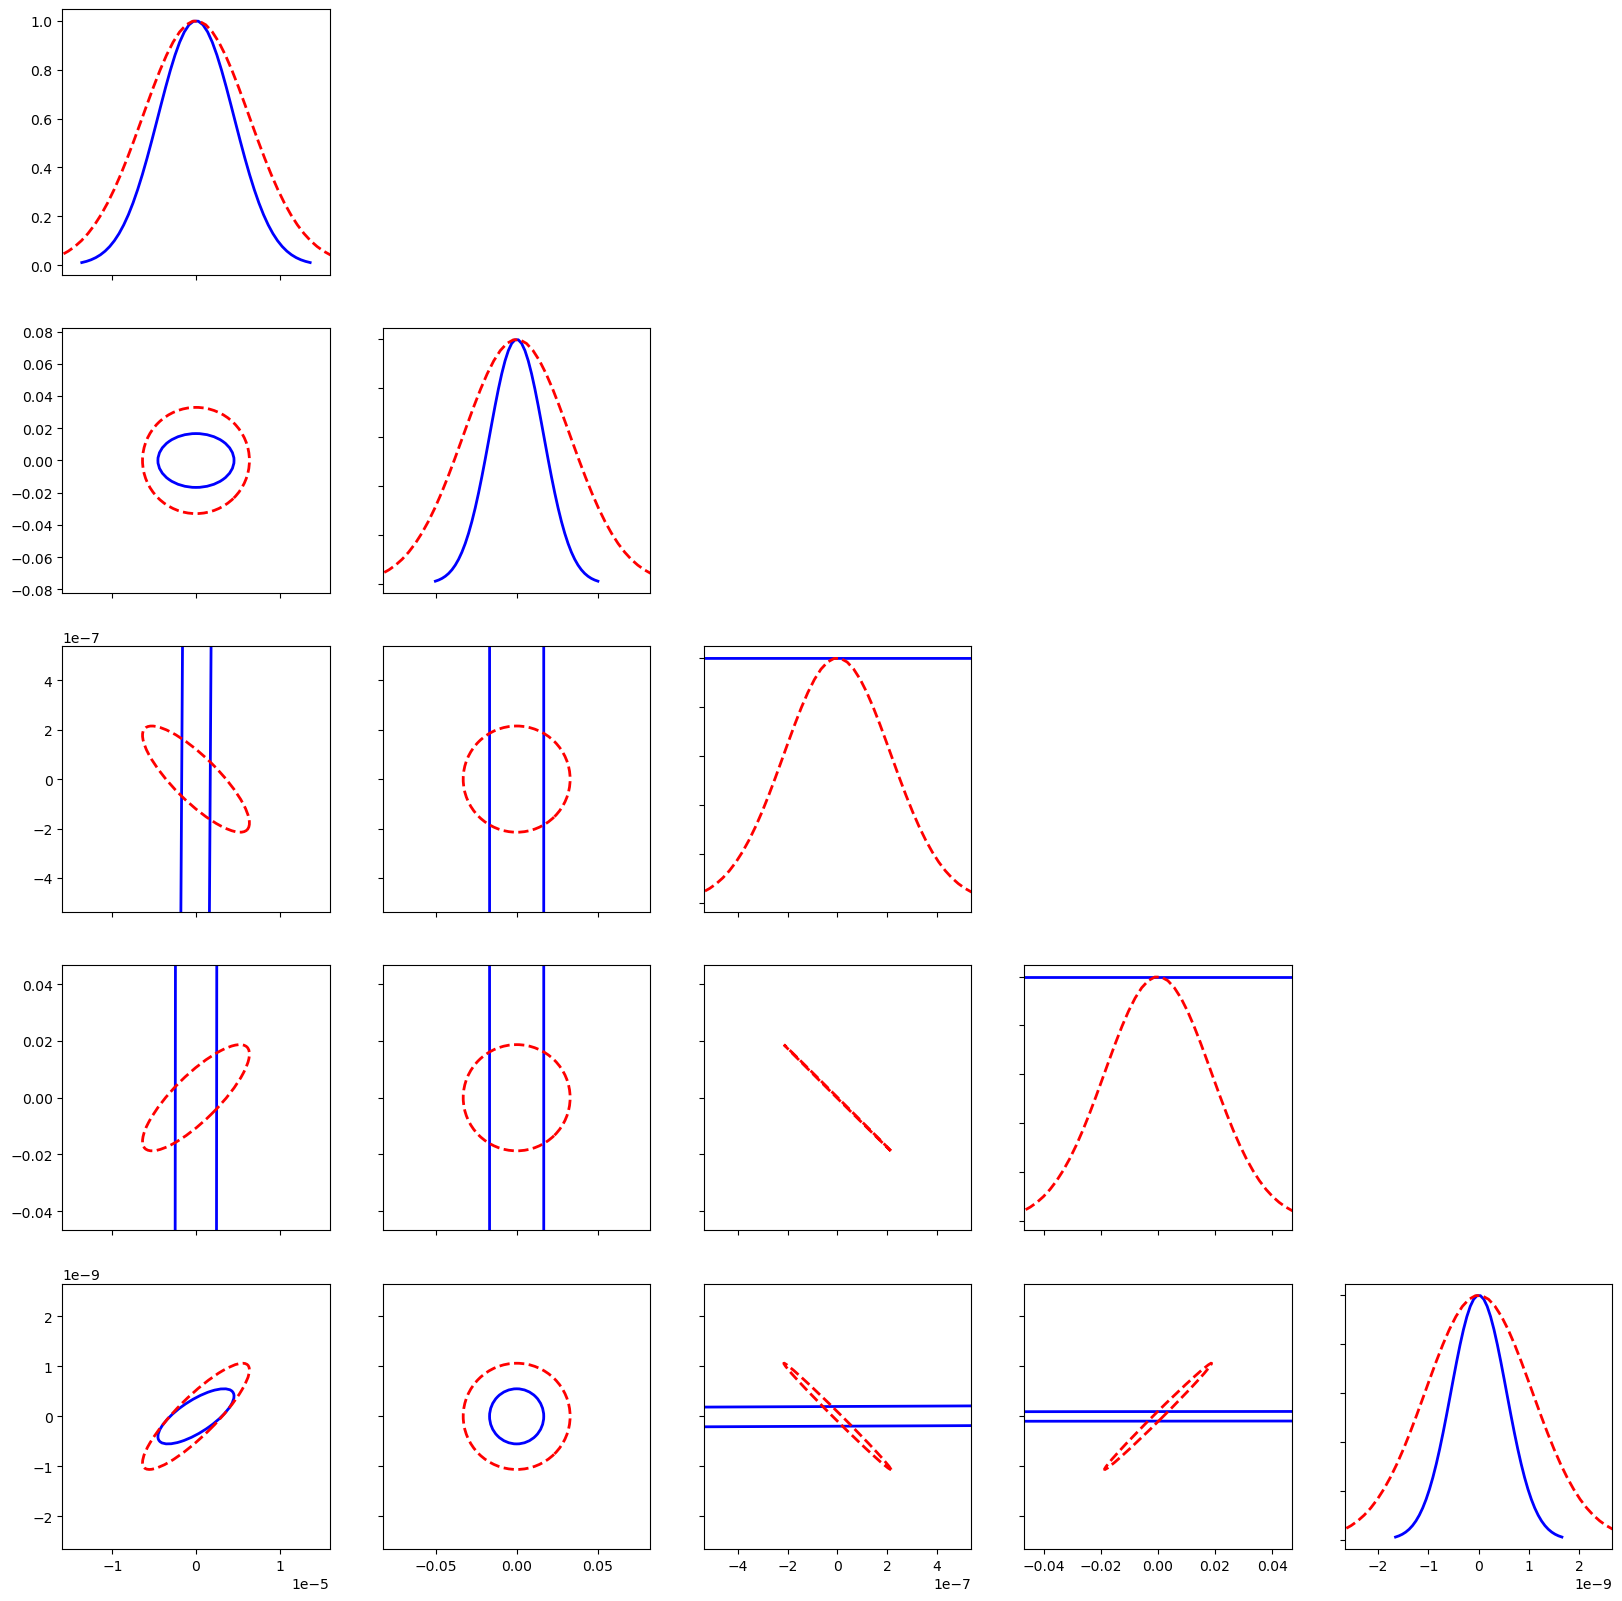

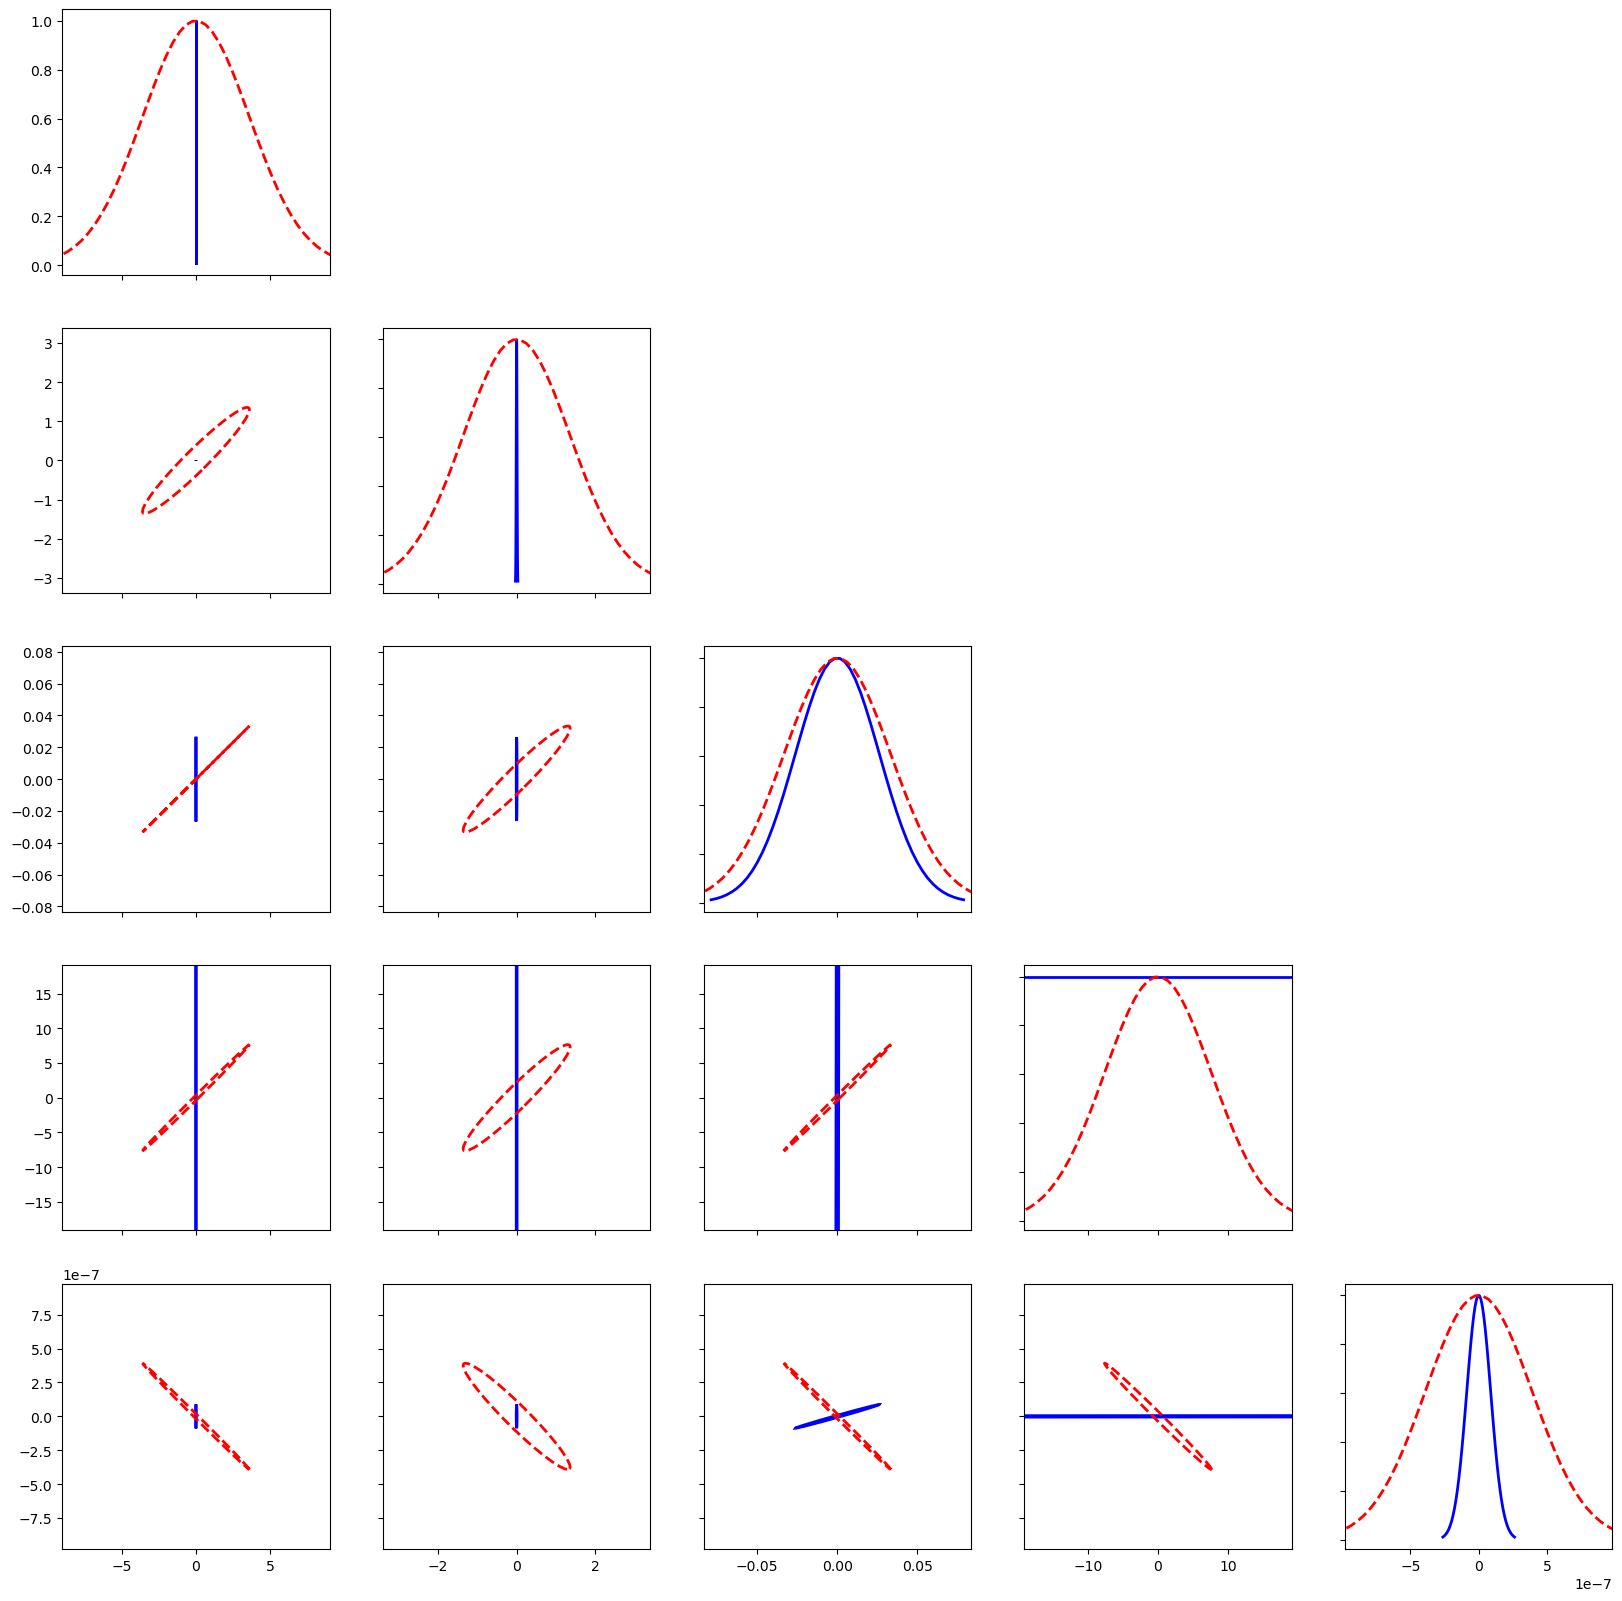

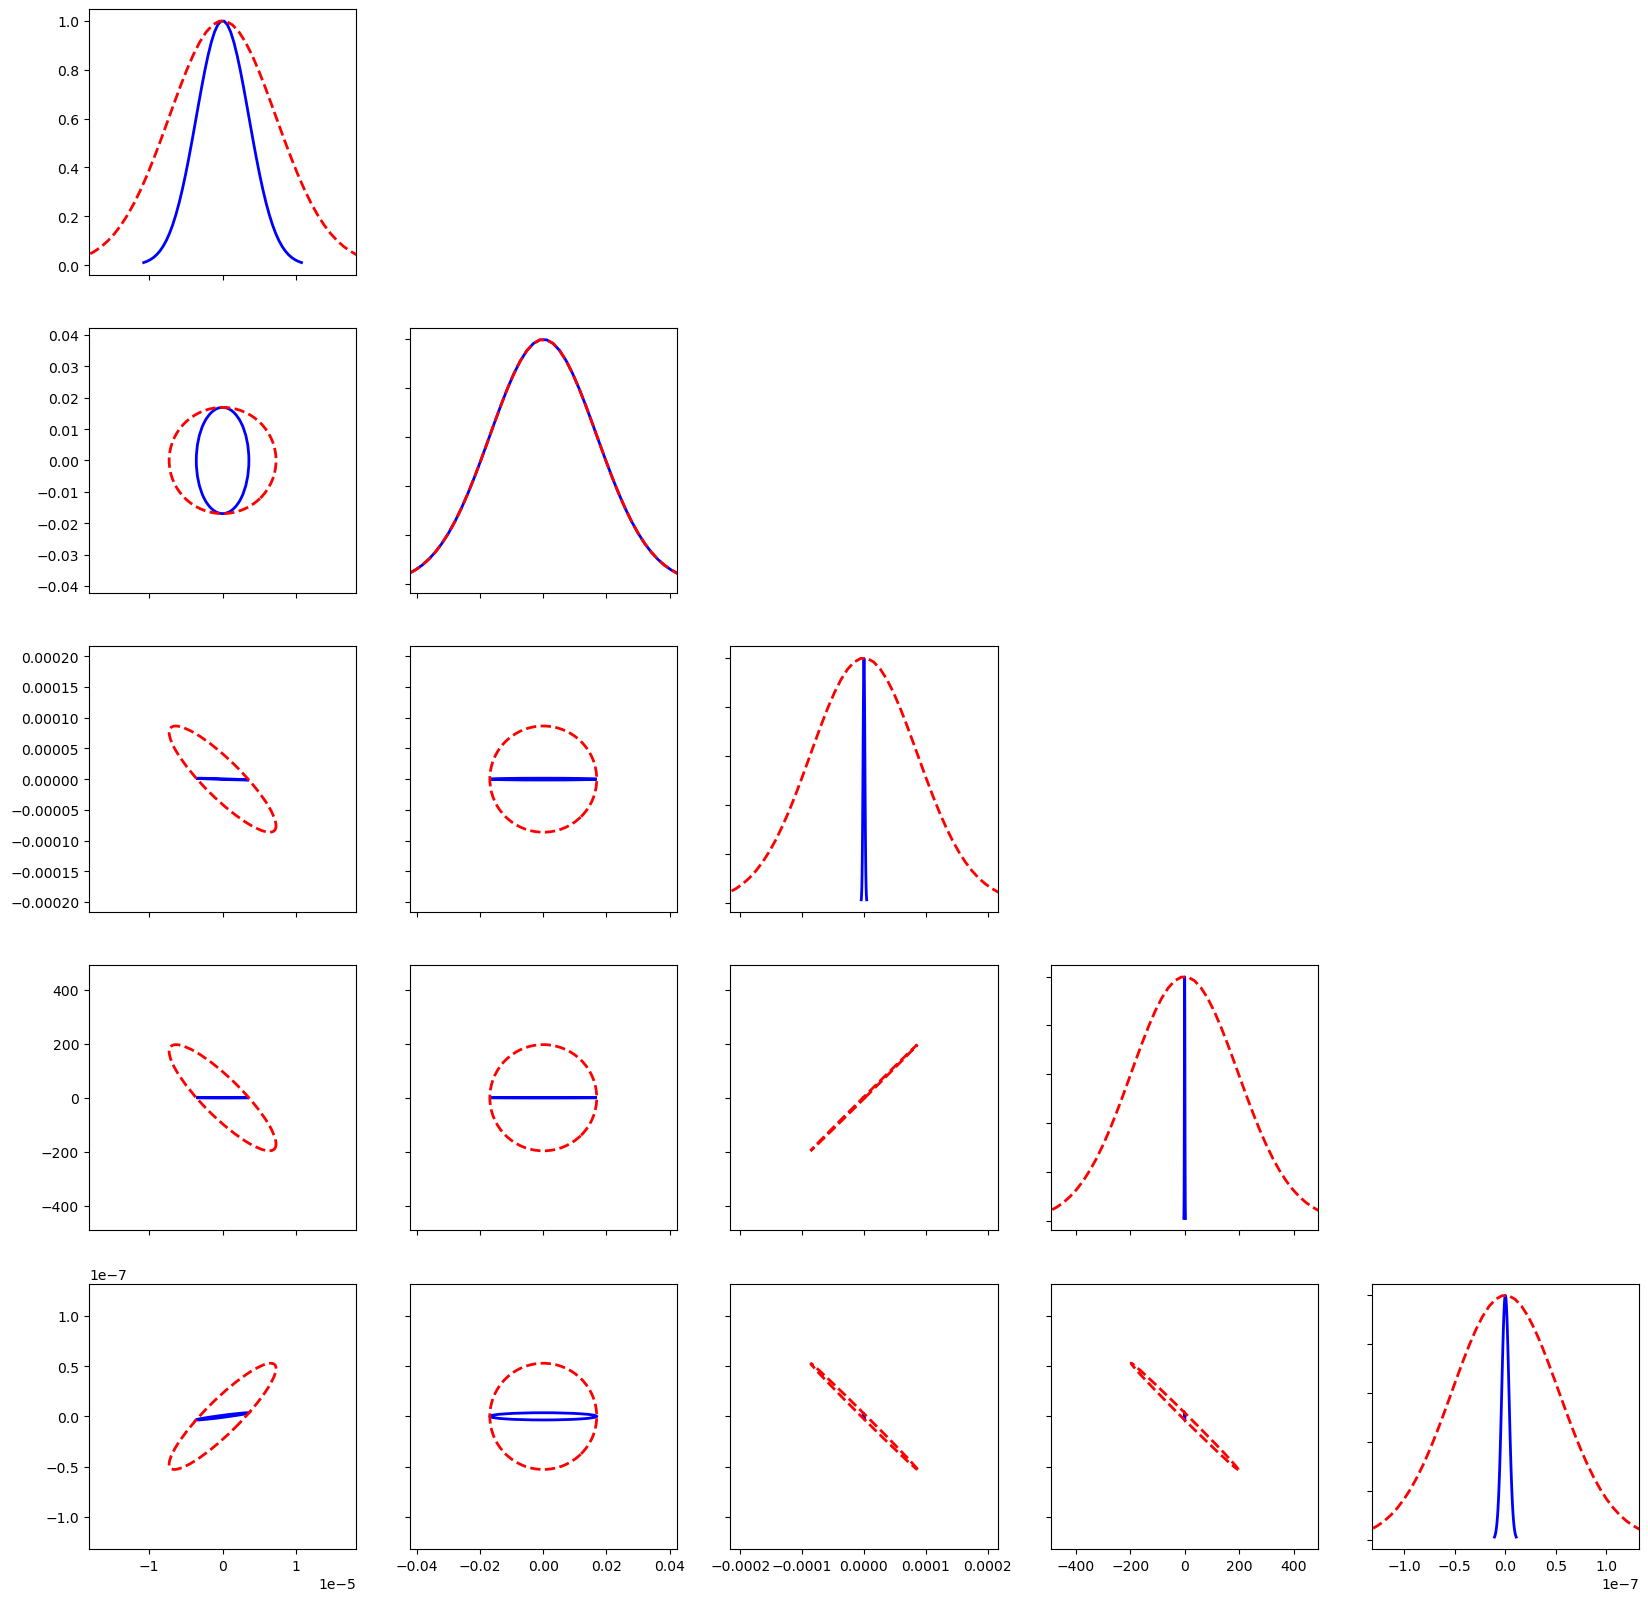

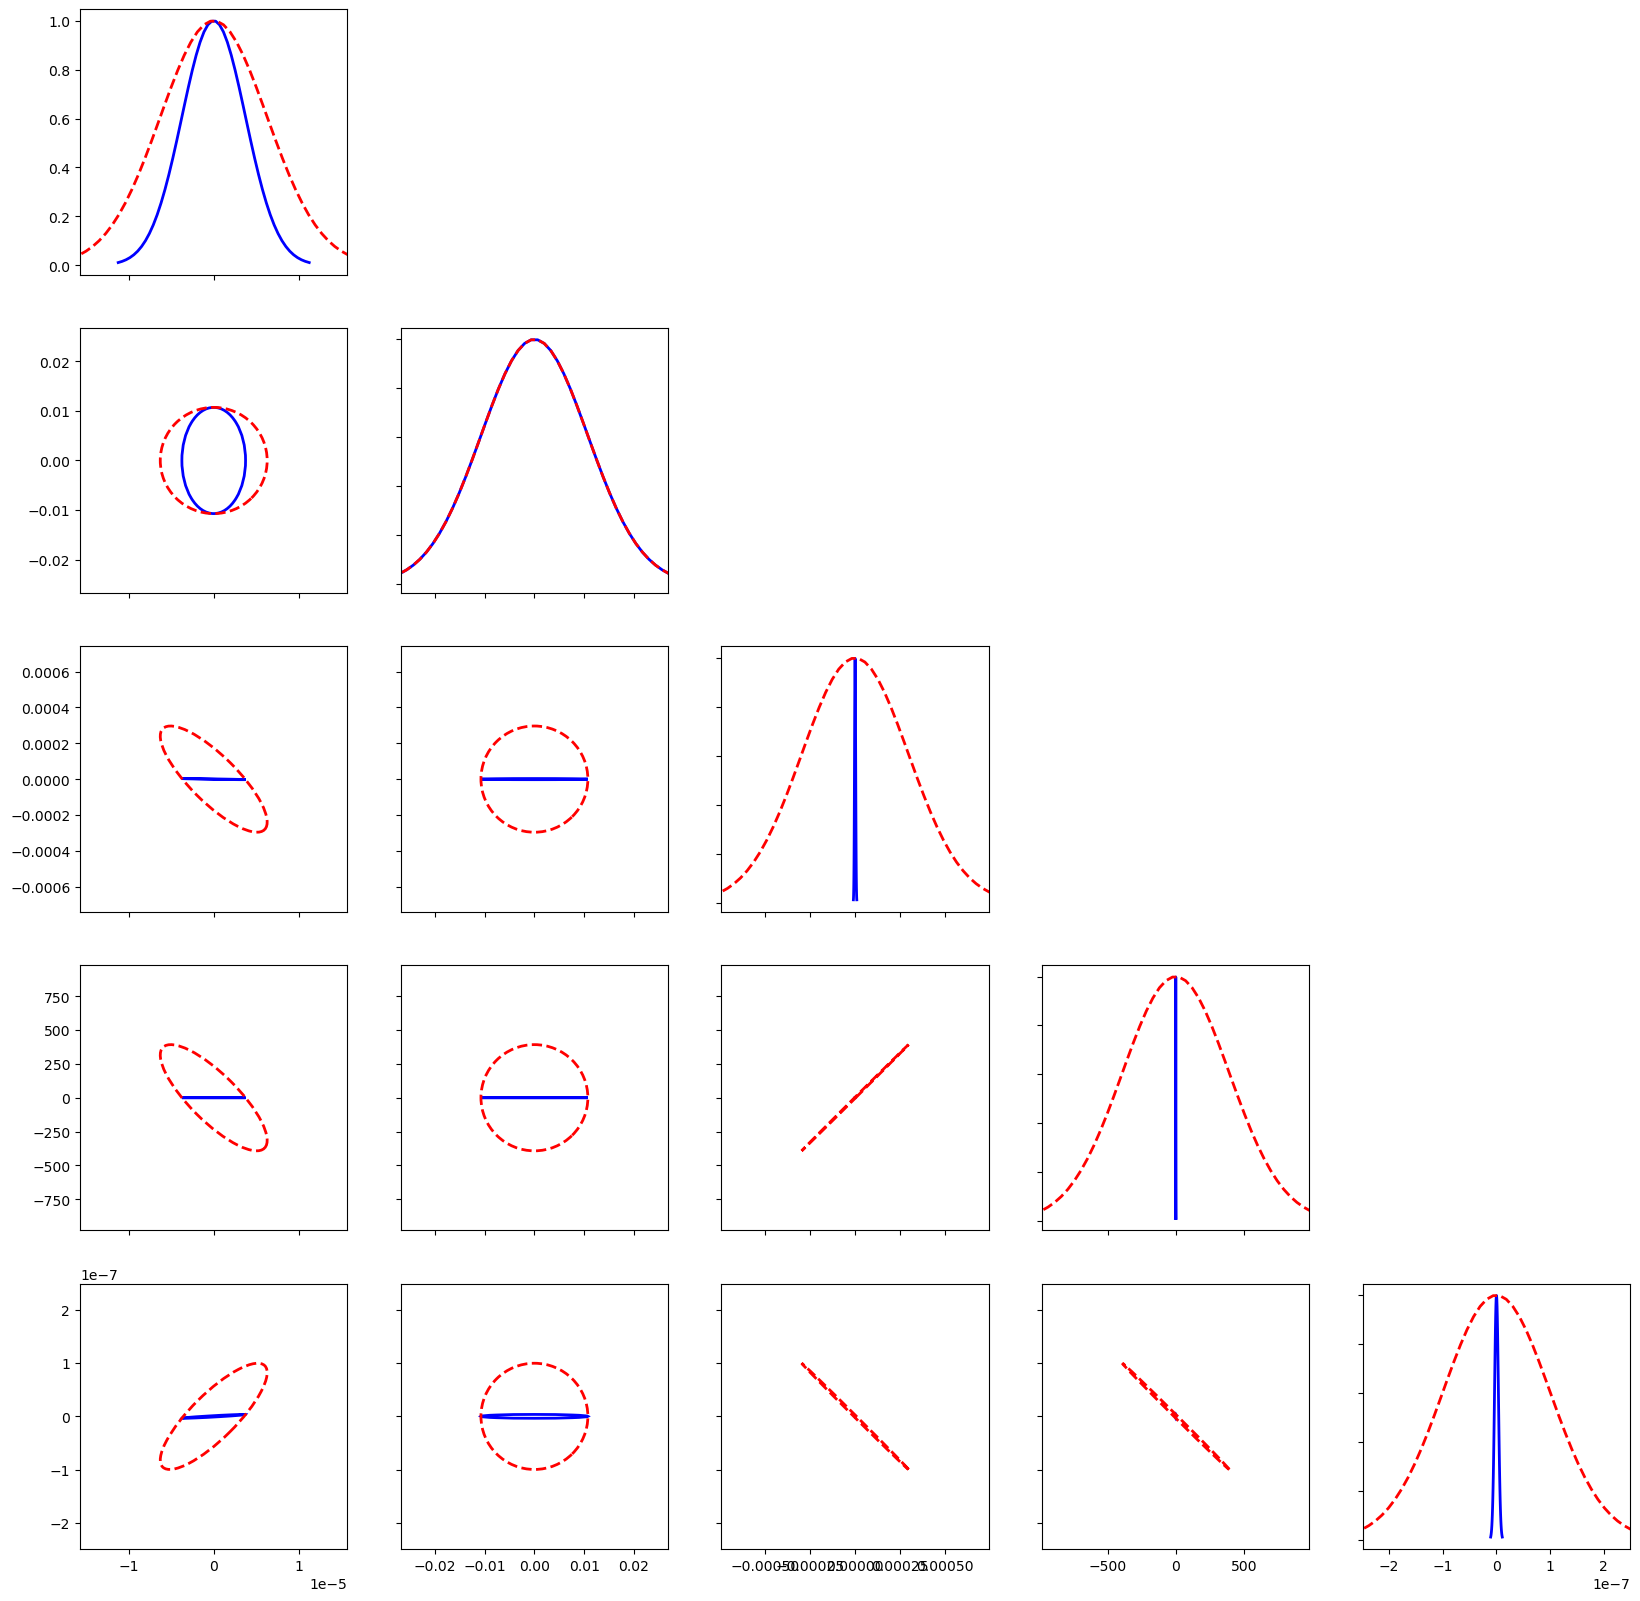

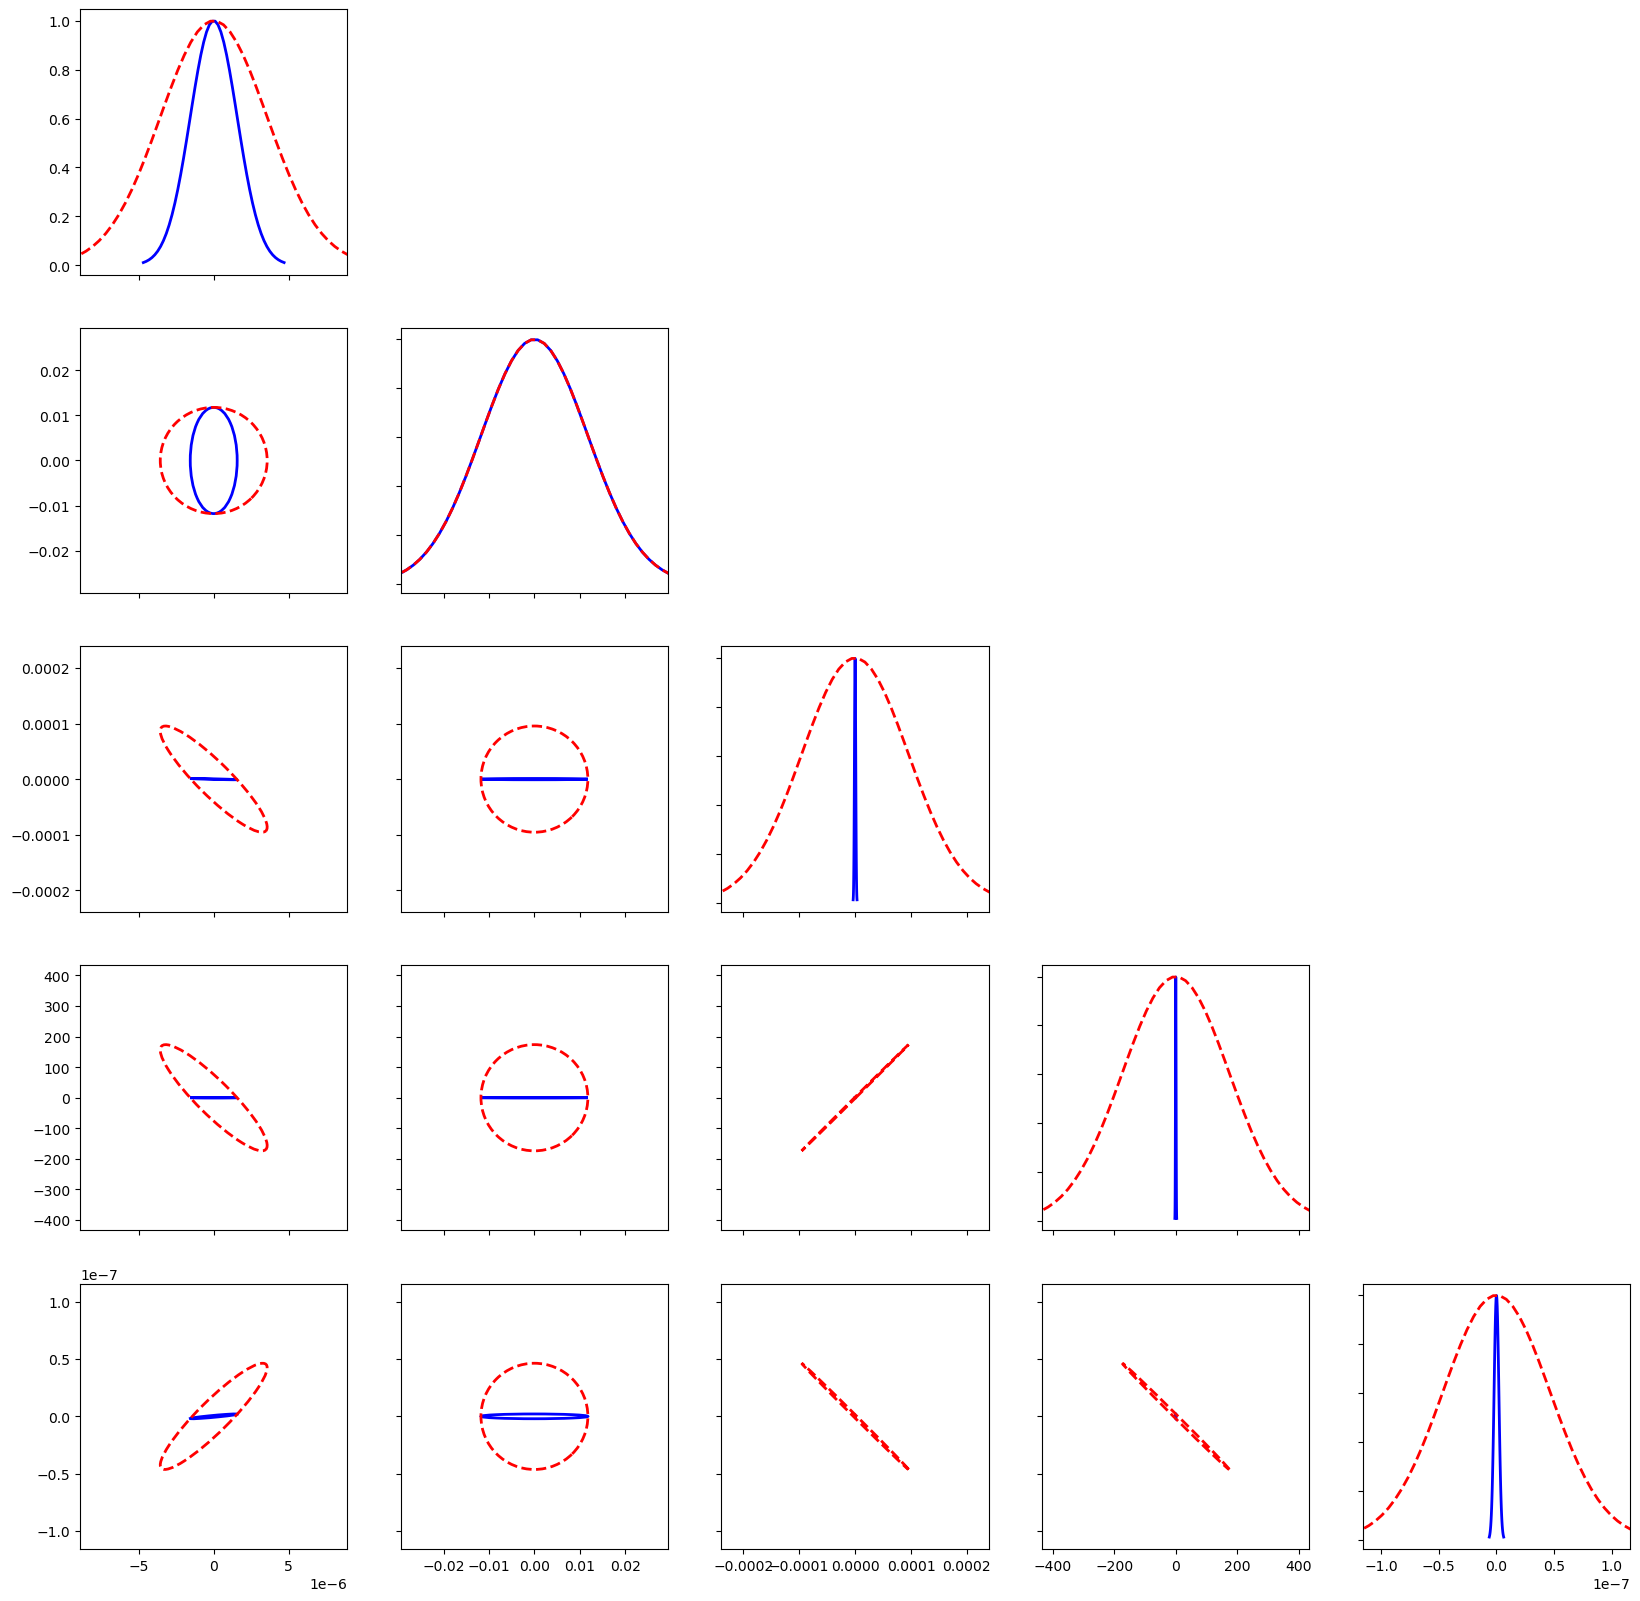

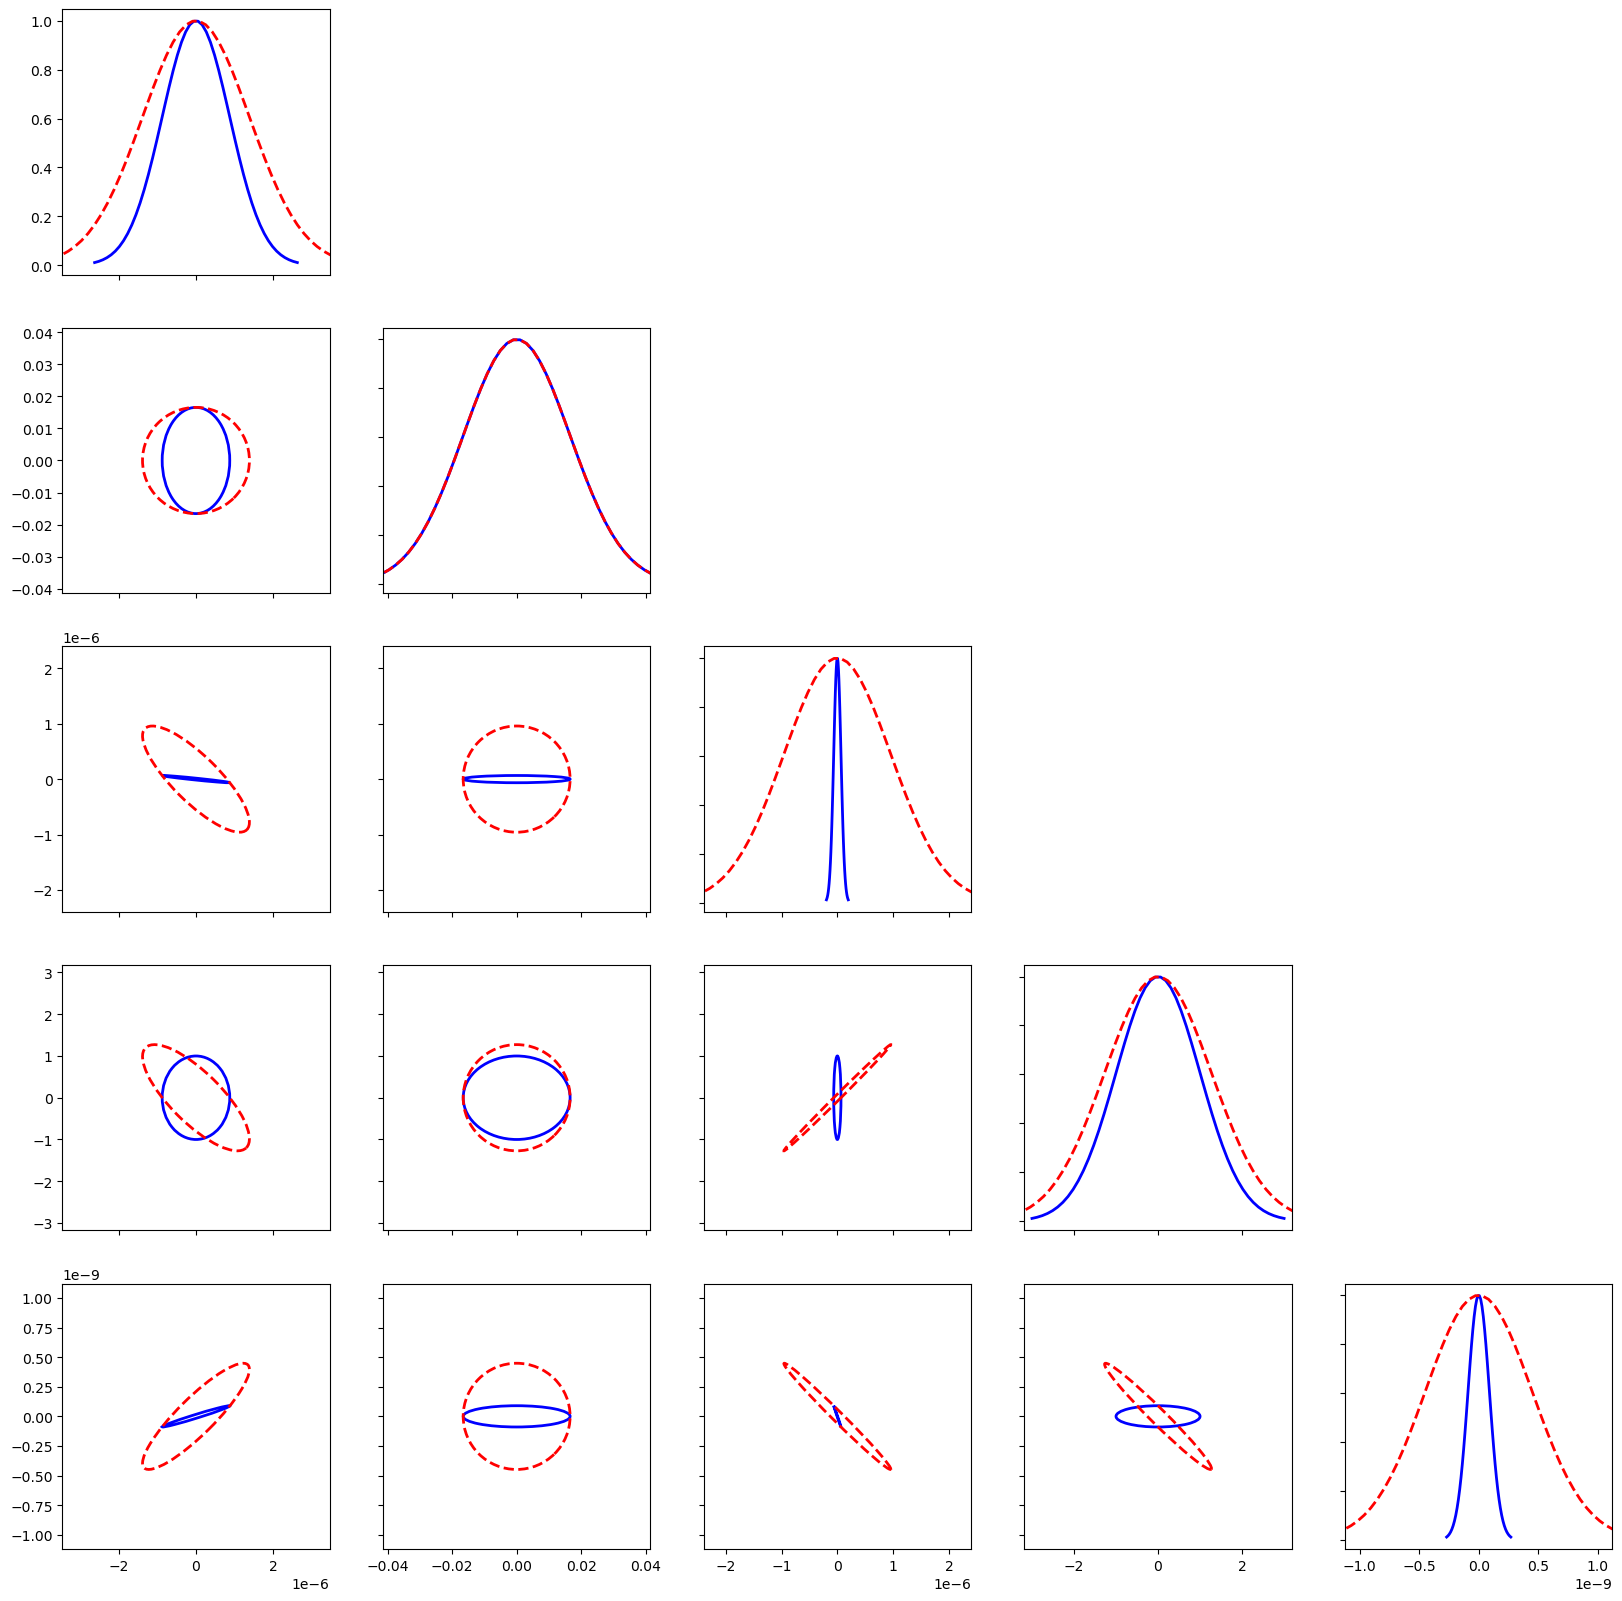

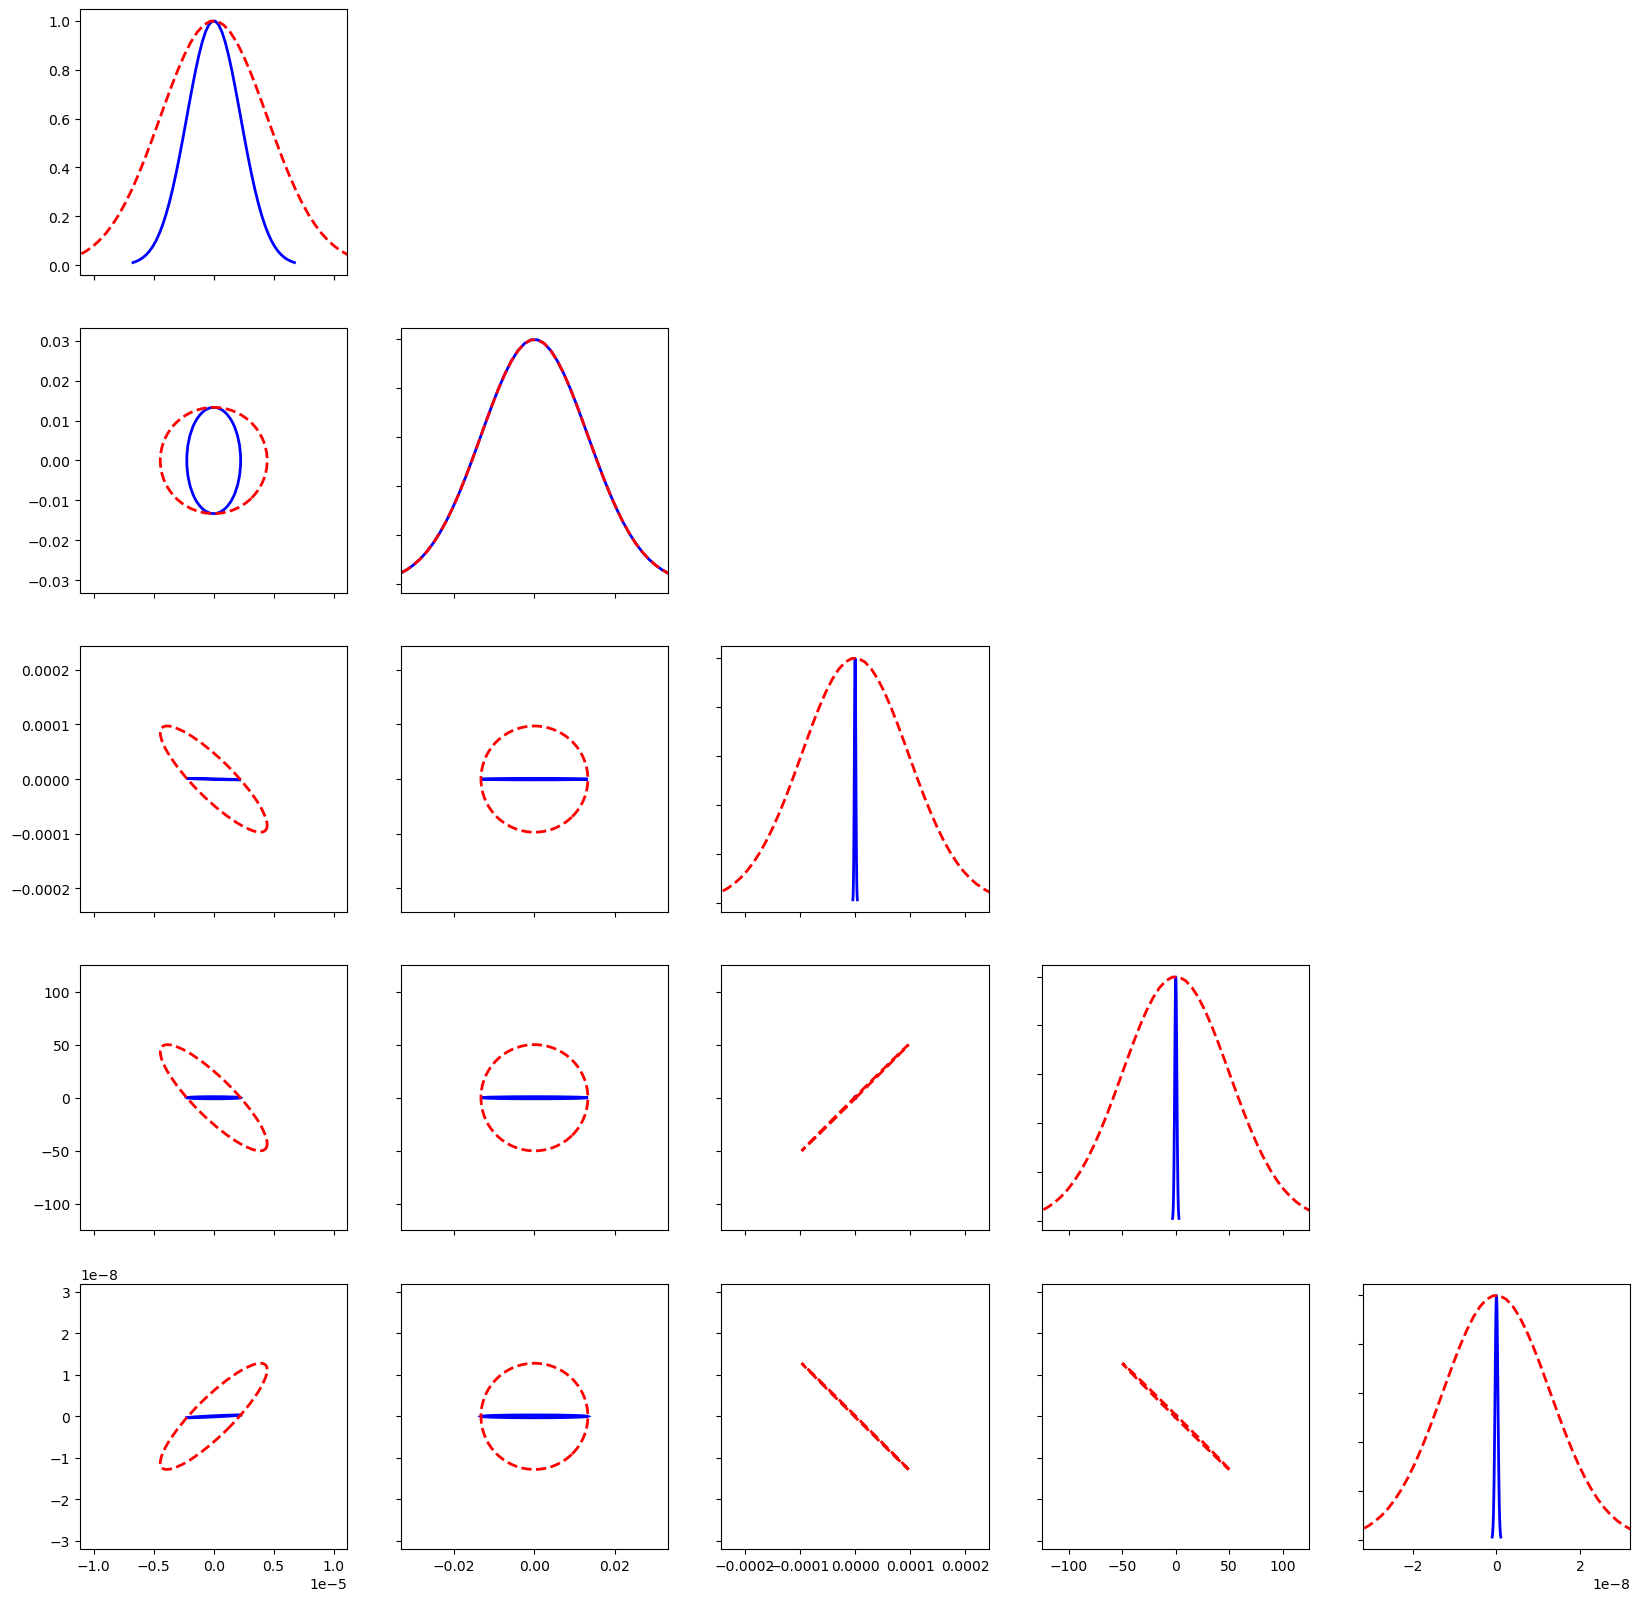

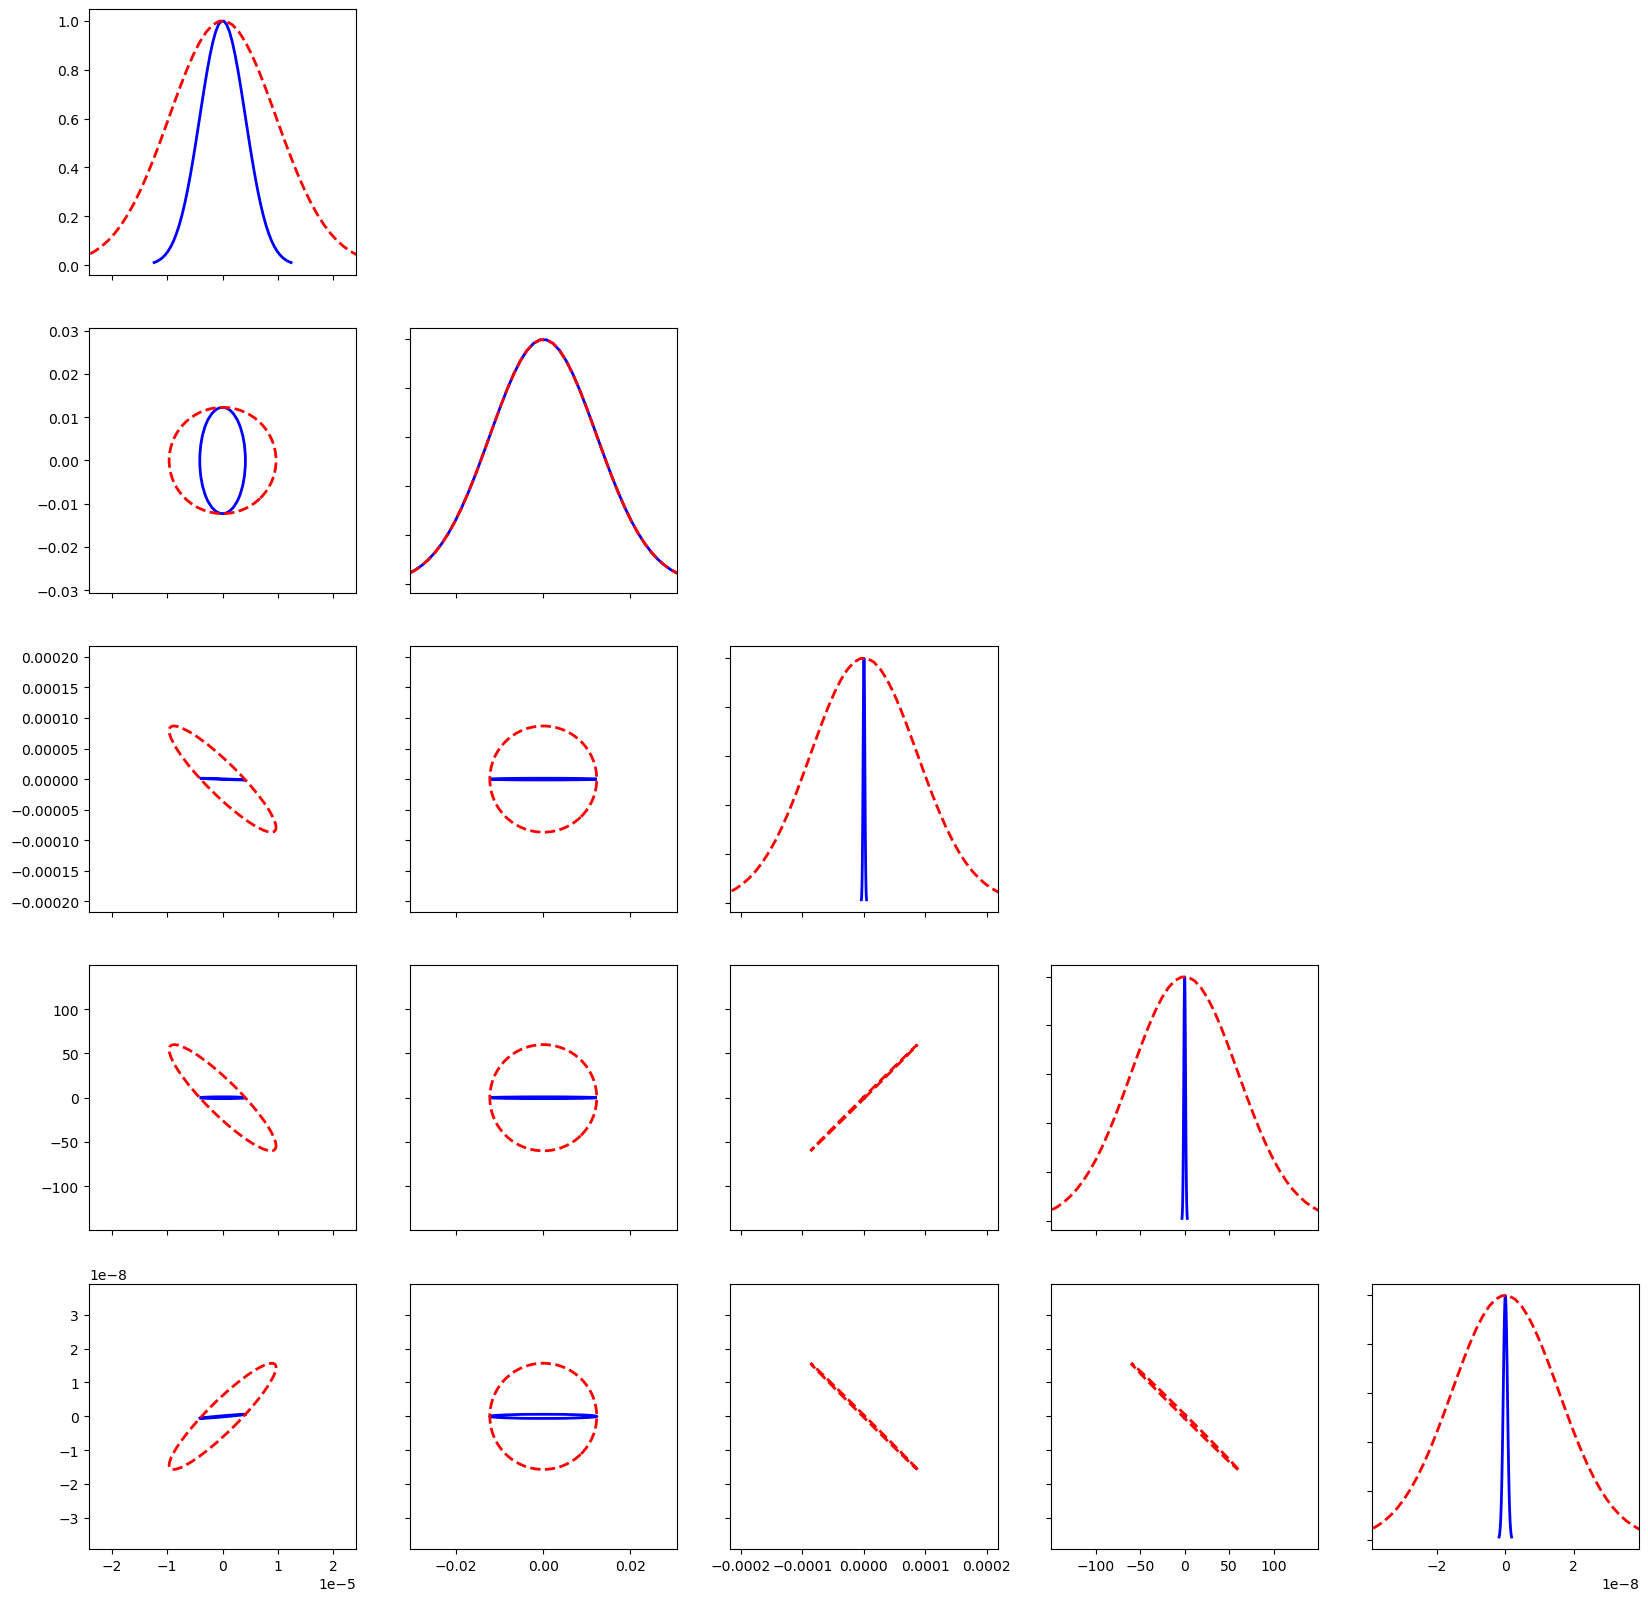

In [6]:
detected_EMRIs = np.load(f"{filename}/detected_EMRIs.npy", allow_pickle=True)

for _ in range(len(detected_EMRIs)):

    index = detected_EMRIs[_]["index"]
    
    #import true Fisher
    with h5py.File(f"{os.path.join(filename, filename_Fishers)}/Fisher_{index}.h5", "r") as f:
        Fisher_true = f["Fisher_transformed"][:]
    
    #import Fisher at local bias
    with h5py.File(f"{os.path.join(filename, filename_Fishers_loc)}/Fisher_{index}.h5", "r") as f:
        Fisher_biased = f["Fisher_transformed"][:]

    fig, axs = CovEllipsePlot(covariance=np.linalg.inv(Fisher_true))

    CovEllipsePlot(covariance=np.linalg.inv(Fisher_biased), fig = fig, axs = axs, color='r', linestyle='--')
    